# Étape 1 — Chargement et exploration initiale

(116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  

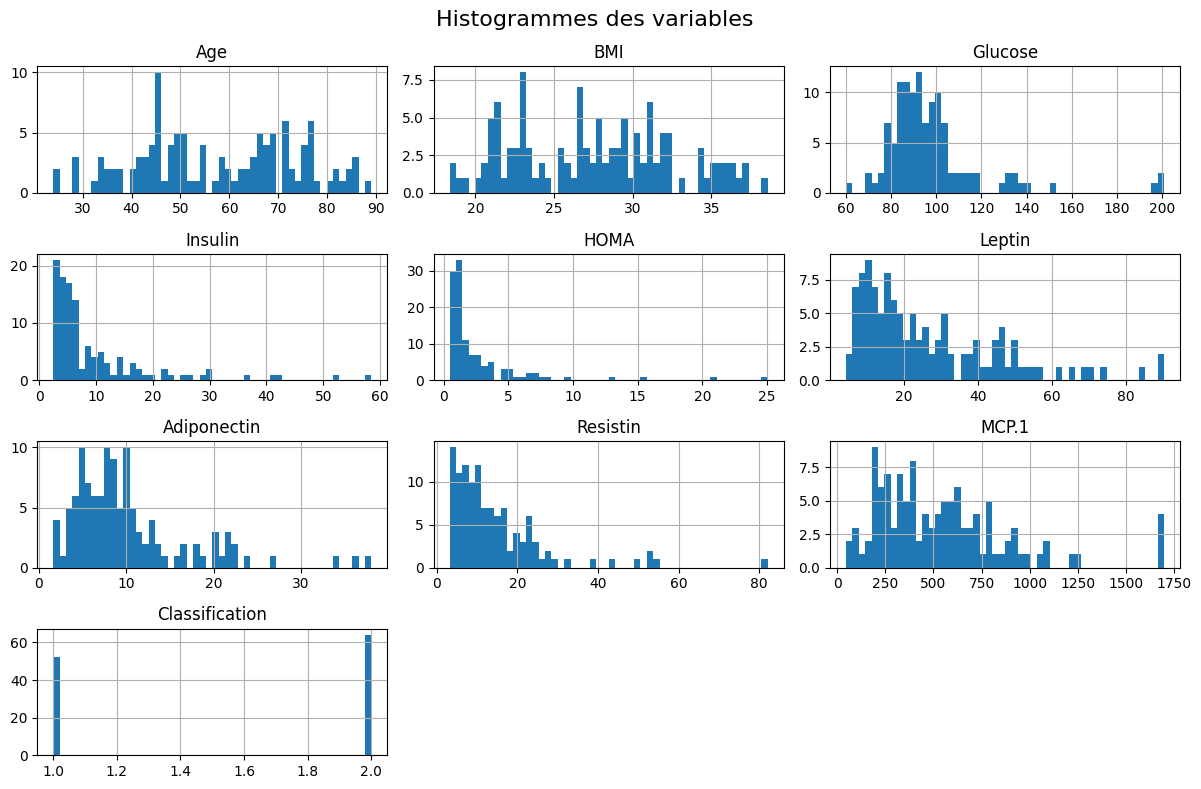

In [32]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('breast+cancer+coimbra/dataR2.csv')

# Aperçu des données
print(data.shape)
print(data.head())
data.info()

# Liste des variables explicatives
features = data.columns[:-1]
print("Les variables explicative sont :", list(features))
target = 'Classification'

# Histogrammes des variables
data.hist(bins=50, figsize=(12, 8))
plt.suptitle("Histogrammes des variables", fontsize=16)
plt.tight_layout()
plt.show()


Nous utilisons ici les données du dataset *Breast Cancer Coimbra*, qui contient des mesures biométriques de 116 patientes. L’objectif est de prédire si une patiente est atteinte d’un cancer du sein ou non, à partir de neuf variables biologiques.

### Aperçu du dataset

Le jeu de données contient 116 observations et 10 variables, dont :
- **9 variables explicatives** continues : `Age`, `BMI`, `Glucose`, `Insulin`, `HOMA`, `Leptin`, `Adiponectin`, `Resistin`, `MCP.1`.
- **1 variable cible** : `Classification`, qui prend la valeur `1` si la patiente est atteinte d’un cancer (positive) et `2` sinon (négative).

Les données ne présentent pas de valeurs manquantes, ce qui permet de procéder directement à l’analyse exploratoire.

### Distribution des variables

La distribution des variables a été visualisée à l’aide d’histogrammes :

- Certaines variables présentent une **distribution asymétrique** avec des valeurs extrêmes, notamment `Insulin`, `HOMA`, `Leptin`, `Adiponectin`, `Resistin` et `MCP.1`. Cela pourra motiver une **transformation des données** ou une **normalisation** avant apprentissage.
- La variable `Classification` est **déséquilibrée**, avec une majorité de patientes saines (`2`). Cette information est importante car elle aura un impact sur le **choix des métriques d’évaluation** : une simple précision (`accuracy`) ne sera pas suffisante pour juger de la qualité des modèles.

Nous allons désormais préparer les données pour l'entraînement des modèles, en séparant les features et la cible, et en effectuant un **split stratifié** du jeu de données.


# Étape 2 — Split du dataset en train et test


In [ ]:
from sklearn.model_selection import train_test_split
# Séparation des features et de la cible
X = data.drop(columns='Classification')
y = data['Classification'].map({2: 0, 1: 1})
# Mapping : 1 = patient malade (positif), 2 = patient sain (négatif)
# On recode pour avoir : 1 → malade (classe positive), 0 → sain


# Split stratifié pour préserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

# Vérification de la forme
print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)


Train : (92, 9) (92,)
Test  : (24, 9) (24,)


Nous commençons par séparer les variables explicatives (features) de la variable cible (`Classification`), en recodant cette dernière pour faciliter l'interprétation des résultats :
- `1` : patiente malade (classe positive),
- `0` : patiente saine (classe négative).

Un **split stratifié** a été effectué à l’aide de la fonction `train_test_split` de `scikit-learn`, afin de préserver la proportion initiale des classes dans les ensembles d’entraînement et de test. Cela est particulièrement important ici compte tenu du **déséquilibre de classes** observé.

Les tailles obtenues sont :
- **Ensemble d'entraînement** : 92 observations
- **Ensemble de test** : 24 observations

Ce découpage correspond à une répartition classique de 80% / 20%.


# Étape 3 — Visualisation des distributions par classe du dataset d'entrainement

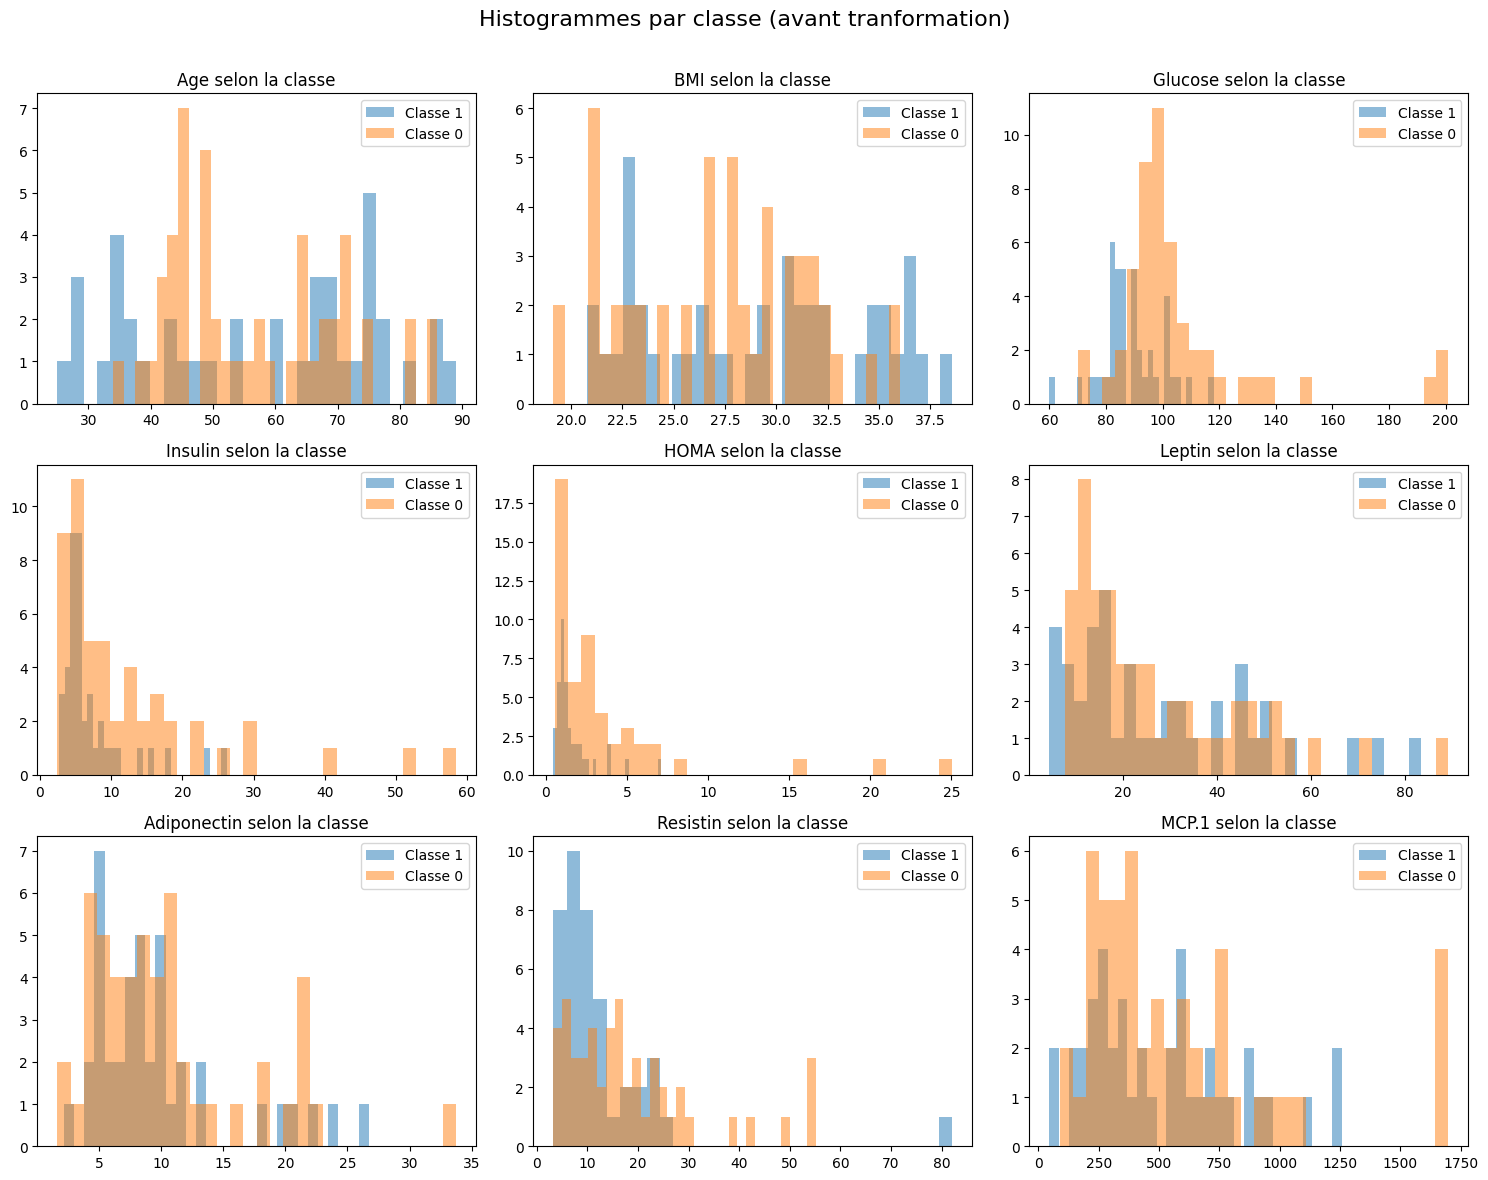

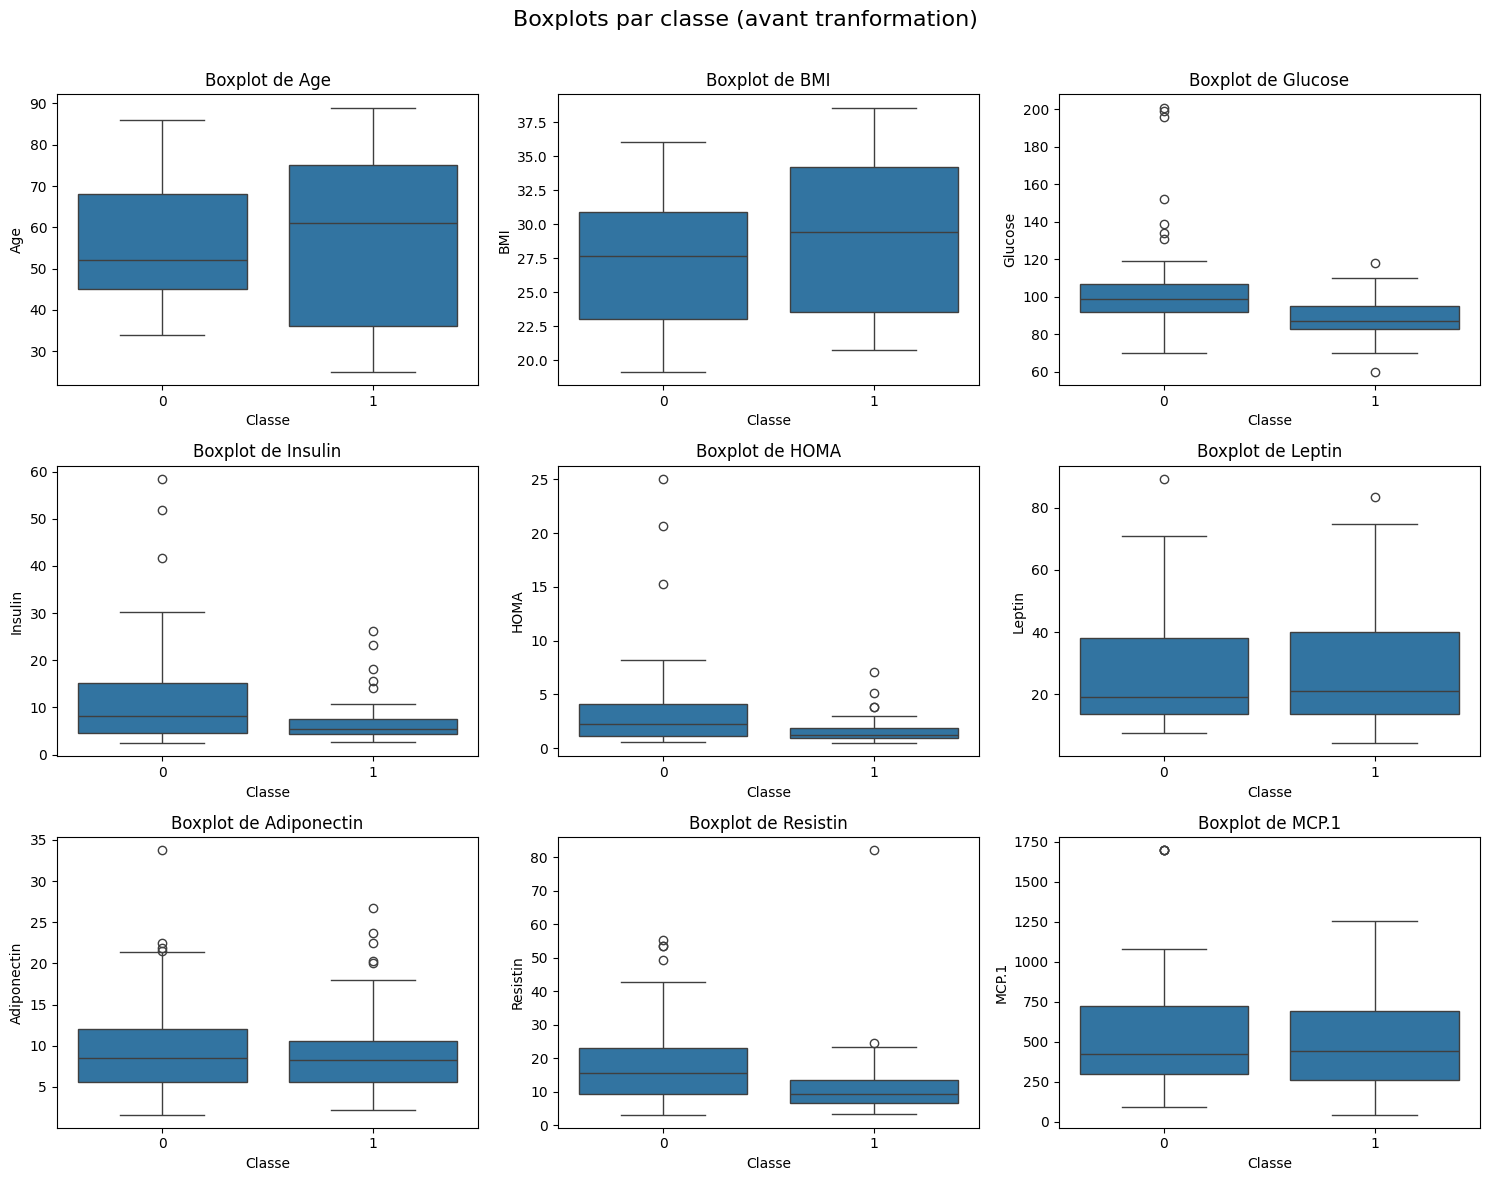

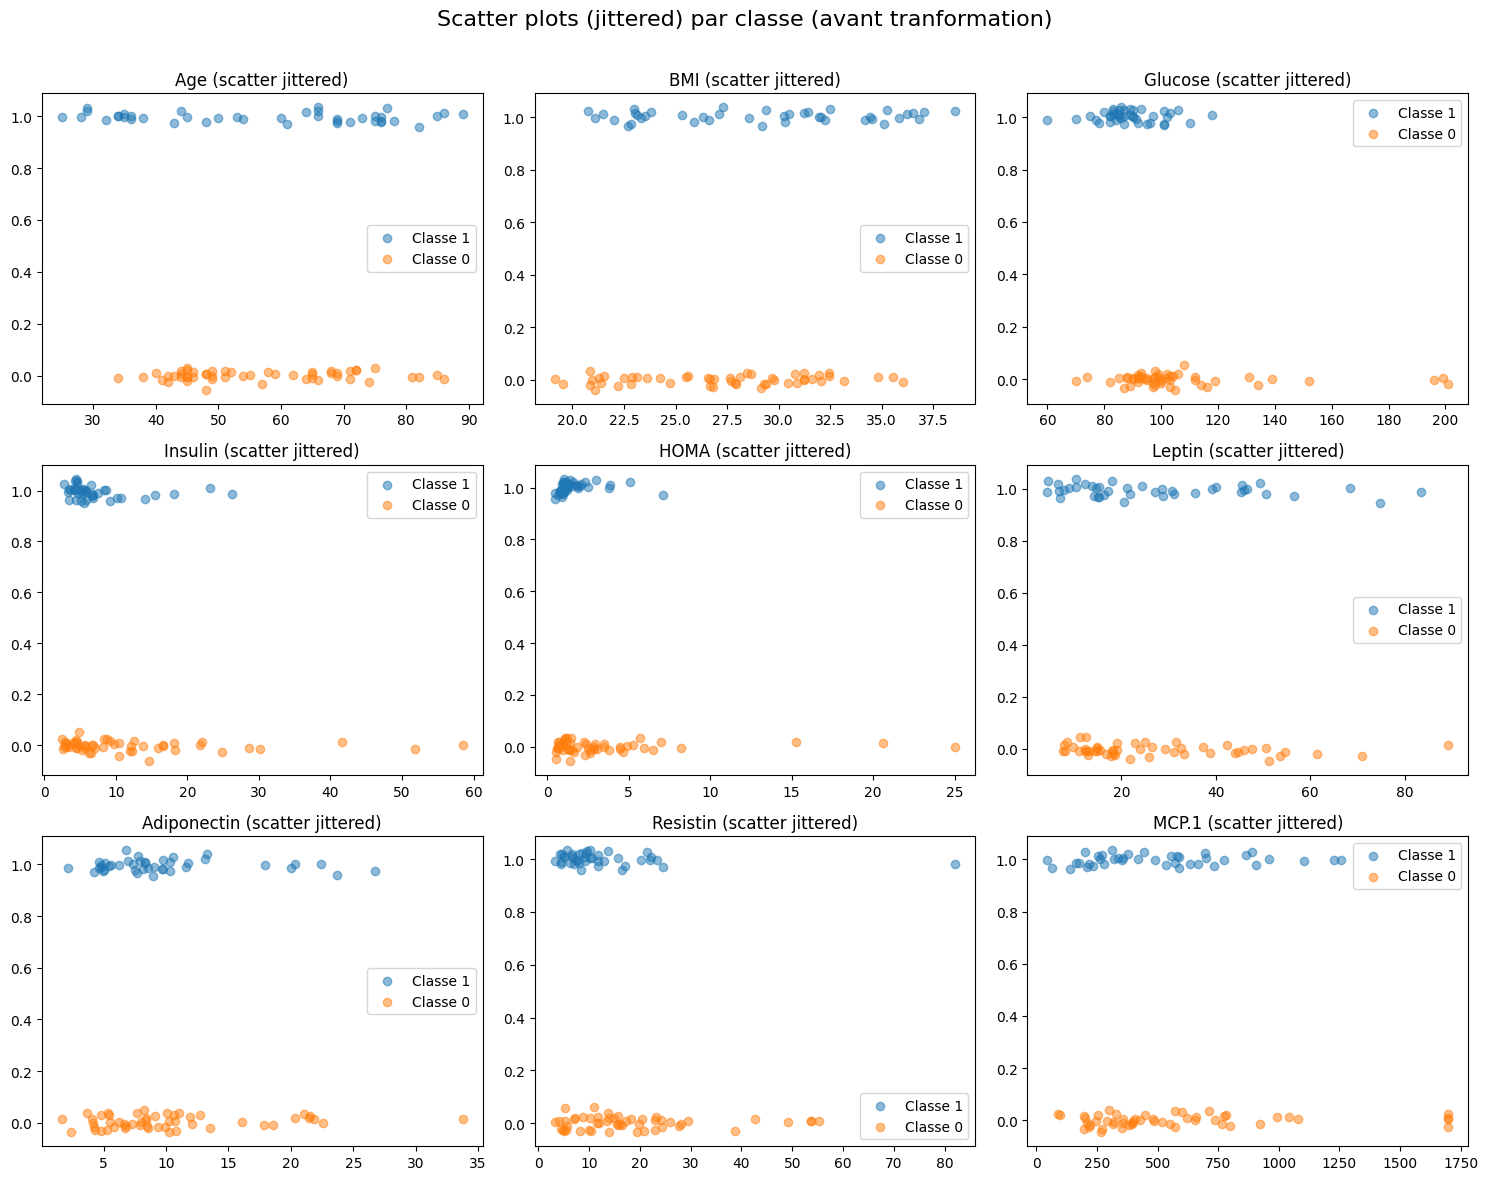

In [31]:
# Fusion temporaire pour les visualisations
train_data = X_train.copy()
train_data['Classification'] = y_train

variables = X_train.columns.tolist()
n_cols = 3
n_rows = int(np.ceil(len(variables) / n_cols))


# Histogrammes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    for classe in y_train.unique():
        axes[i].hist(X_train[y_train == classe][col], bins=30, alpha=0.5, label=f"Classe {classe}")
    axes[i].set_title(f"{col} selon la classe")
    axes[i].legend()
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histogrammes par classe (avant tranformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    sns.boxplot(x=y_train, y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots par classe (avant tranformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Scatter plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    for classe in y_train.unique():
        axes[i].scatter(
            X_train[y_train == classe][col],
            np.random.normal(loc=classe, scale=0.02, size=X_train[y_train == classe][col].shape),
            alpha=0.5,
            label=f"Classe {classe}"
        )
    axes[i].set_title(f"{col} (scatter jittered)")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Scatter plots (jittered) par classe (avant tranformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Afin de mieux comprendre les différences entre les patientes malades (`Classe 1`) et les patientes saines (`Classe 0`), nous avons représenté les distributions des variables explicatives en les segmentant par classe. Trois types de visualisations complémentaires ont été produits : histogrammes, boxplots et scatter plots jittered.

### Histogrammes par classe

Les histogrammes permettent d'observer la distribution des valeurs au sein de chaque classe. Plusieurs variables présentent des décalages notables entre les deux groupes, notamment :
- **Age** : les patientes malades ont tendance à être légèrement plus âgées.
- **Resistin**, **MCP.1** et **Adiponectin** semblent présenter des décalages de densité entre les deux classes, suggérant un potentiel pouvoir discriminant.
- À l'inverse, des variables comme **BMI** ou **Leptin** montrent une forte superposition entre les classes.

Ces observations qualitatives suggèrent que certaines variables pourraient être informatives, mais **aucune ne permet à elle seule une séparation nette**.

### Boxplots par classe

Les boxplots permettent une évaluation visuelle plus précise des différences de distribution :
- La majorité des variables présentent une **forte dispersion** avec de nombreux **outliers** visibles dans les deux classes, en particulier pour `Insulin`, `Leptin` et `MCP.1`.
- **Les médianes sont proches**, mais on note quelques différences de tendance (ex. `Resistin` plus élevée pour la classe 1).

Ces éléments indiquent une **variance importante intra-classe**, ce qui pourrait affecter les performances de modèles sensibles aux échelles non standardisées.

### Scatter plots (jittered)

Ces visualisations montrent explicitement la séparation verticale entre les classes (0 ou 1) :
- Aucune variable seule ne suffit à séparer totalement les classes.
- Certains regroupements apparaissent (ex. des valeurs faibles de `Insulin`, `HOMA`, `Adiponectin` associées à la classe 0), mais avec un **chevauchement significatif**.

---

###  Bilan de l’analyse exploratoire

- Les variables semblent contenir **un signal partiel**, mais nécessiteront d’être **combinées dans un modèle multivarié** pour exploiter au mieux les interactions.
- La présence d’**outliers**, de **distributions asymétriques** et de **valeurs sur des échelles très différentes** justifie :
  - une **standardisation préalable** des variables,
  - et éventuellement une **transformation** logarithmique pour certaines (ex. `Insulin`, `Leptin`, `HOMA`).
- Enfin, la forte **superposition inter-classe** implique que la séparation linéaire pourrait être limitée, ce qui motivera l’usage de modèles non linéaires.

Cette étape exploratoire permet donc de motiver rigoureusement les choix de **prétraitement** et de **modélisation supervisée** qui suivront.


# Étape 4 — Matrice de corrélation et scatter matrix (train uniquement)

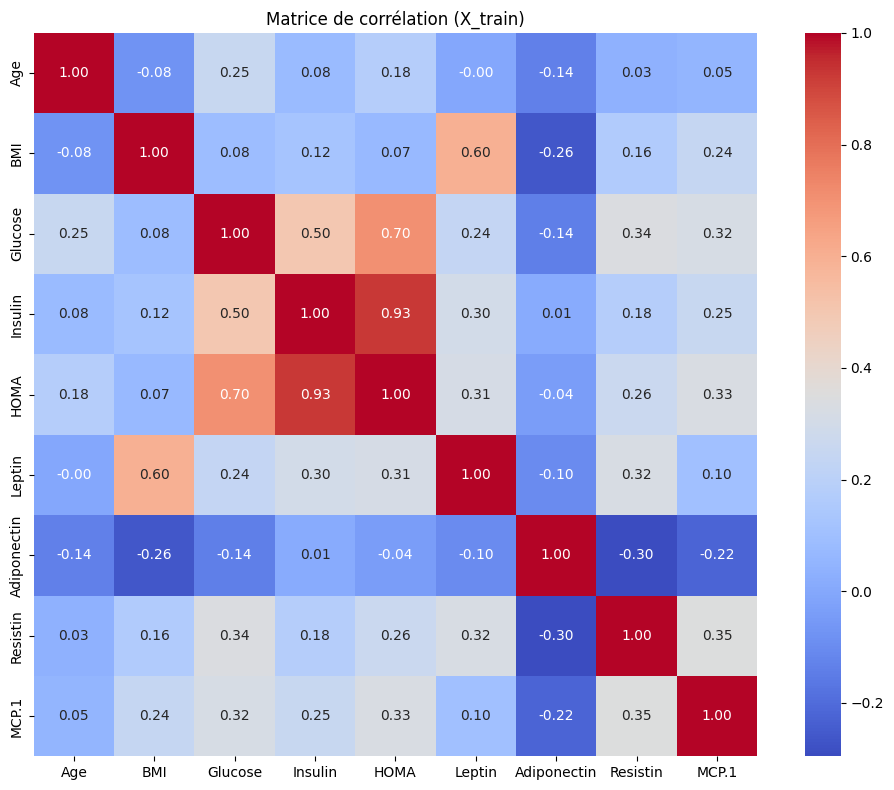

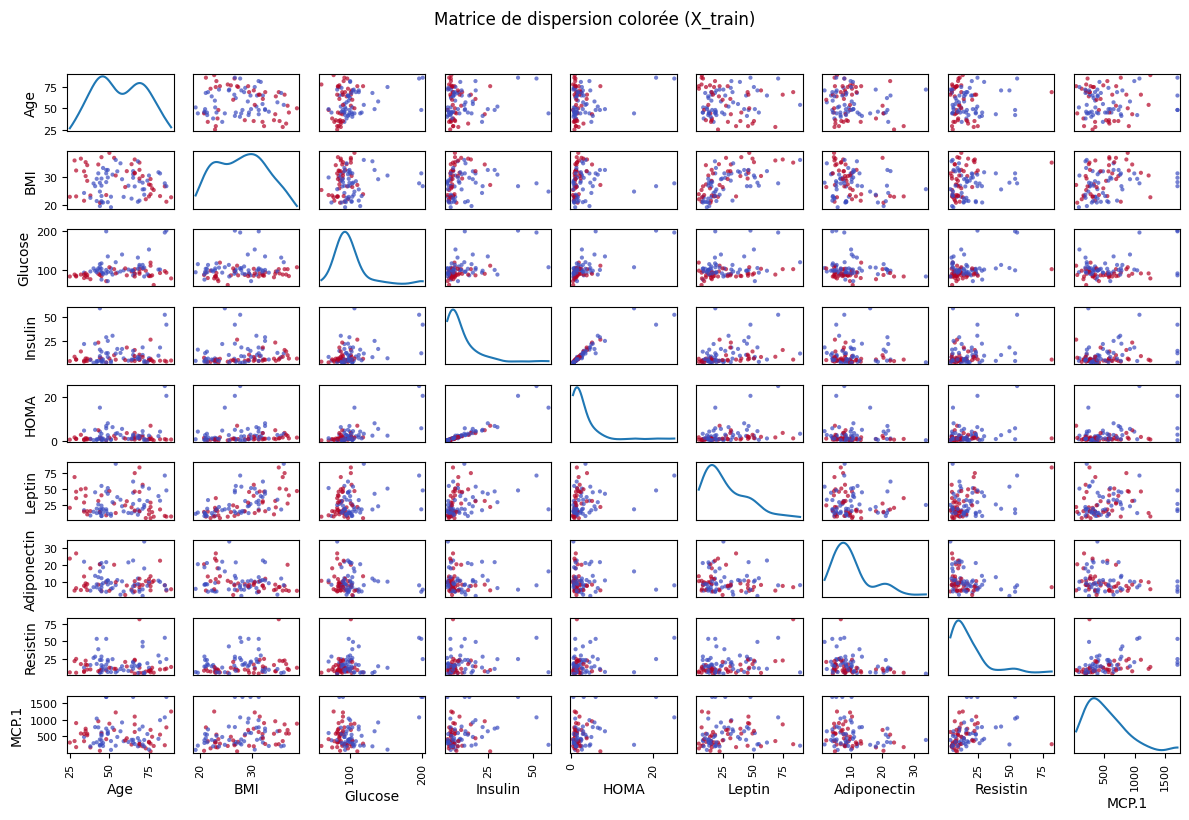

In [24]:
from pandas.plotting import scatter_matrix
# Matrice de corrélation (sur les données d'entraînement)
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation (X_train)")
plt.tight_layout()
plt.show()

# DataFrame combiné pour visualisation colorée
X_train_visu = X_train.copy()
X_train_visu['Classification'] = y_train.values

# Scatter matrix colorée
scatter_matrix(X_train_visu.drop(columns='Classification'),
               figsize=(12, 8),
               diagonal='kde',
               c=X_train_visu['Classification'],
               cmap='coolwarm',
               alpha=0.7)
plt.suptitle("Matrice de dispersion colorée (X_train)", y=1.02)
plt.tight_layout()
plt.show()



Afin d’examiner la redondance potentielle entre les variables et d’anticiper les risques de multicolinéarité, nous avons étudié les relations linéaires entre les variables explicatives à l’aide de deux outils complémentaires :

### Matrice de corrélation

La matrice de corrélation permet d’identifier les relations linéaires entre les variables continues. On observe notamment :

- Une **corrélation très forte** entre `Insulin` et `HOMA` (ρ ≈ 0.93), ce qui est attendu puisque HOMA est une fonction de l’insuline et de la glycémie (`HOMA = (Glucose × Insulin) / 405`).
- Des corrélations modérées entre :
  - `Glucose` et `HOMA` (ρ ≈ 0.70),
  - `BMI` et `Leptin` (ρ ≈ 0.60).
- Les autres paires présentent des corrélations relativement faibles (ρ < 0.4), ce qui suggère que **la majorité des variables apportent une information complémentaire**.

Cette analyse nous incite à envisager éventuellement une **réduction de dimension** ou une **sélection de variables**, en particulier si certaines méthodes sont sensibles à la colinéarité (ex. régression logistique).

### Matrice de dispersion colorée

La scatter matrix, colorée selon la classe (`Classification`), donne une vision globale des interactions deux-à-deux entre variables, tout en mettant en évidence les regroupements selon la classe.

- On note un **chevauchement significatif** entre les deux classes dans la majorité des projections planes.
- Quelques combinaisons de variables, comme (`Resistin`, `MCP.1`) ou (`Adiponectin`, `HOMA`), montrent des séparations partielles entre les classes, sans pour autant être suffisantes pour une séparation nette.

---

### Conclusion de cette étape

- Il n’existe pas de **séparation linéaire évidente** entre les deux classes sur les paires de variables.
- La structure du jeu de données suggère que des méthodes multivariées pourront tirer profit de **relations complexes**, éventuellement **non linéaires**.
- La **standardisation** sera nécessaire avant d’appliquer certaines méthodes sensibles aux échelles (SVM, k-NN, PCA...).

Nous passons maintenant à l’étape de prétraitement (standardisation des données), avant de comparer différentes méthodes d’apprentissage supervisé.


# Étape 5 — Transformation logarithmique 

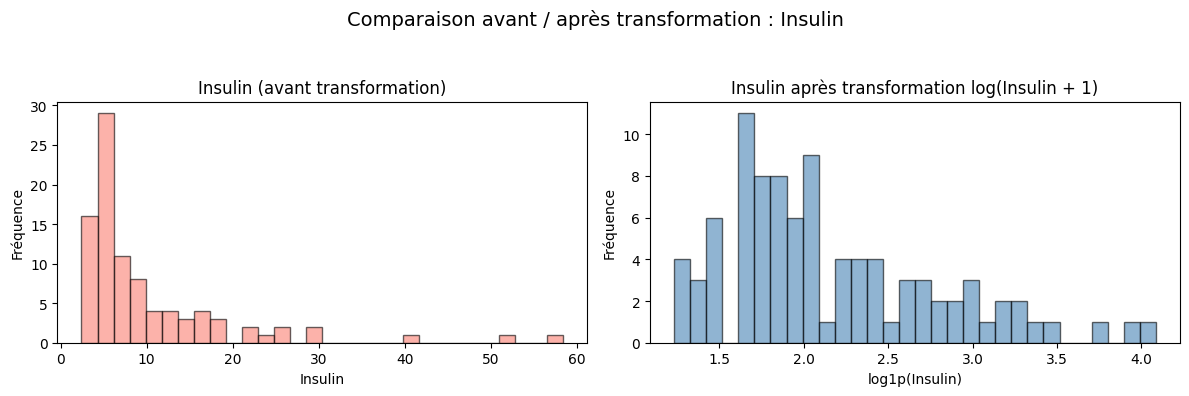

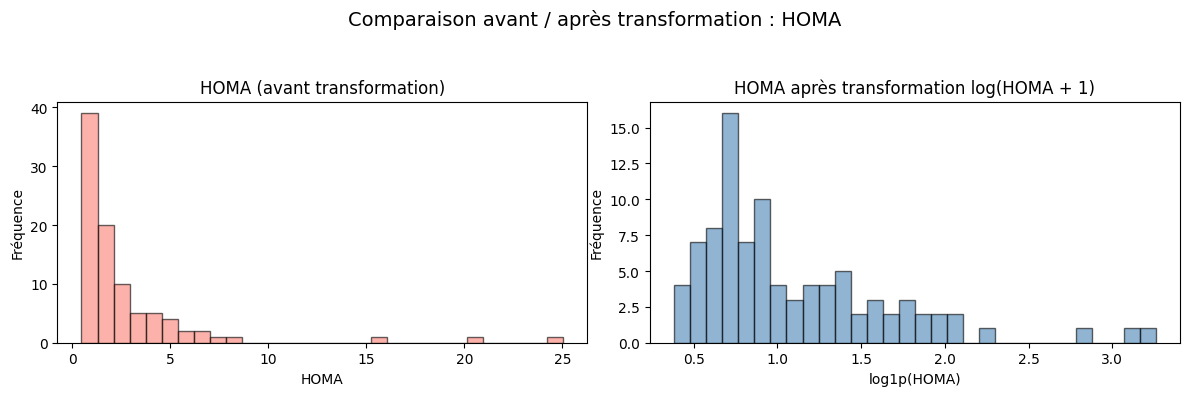

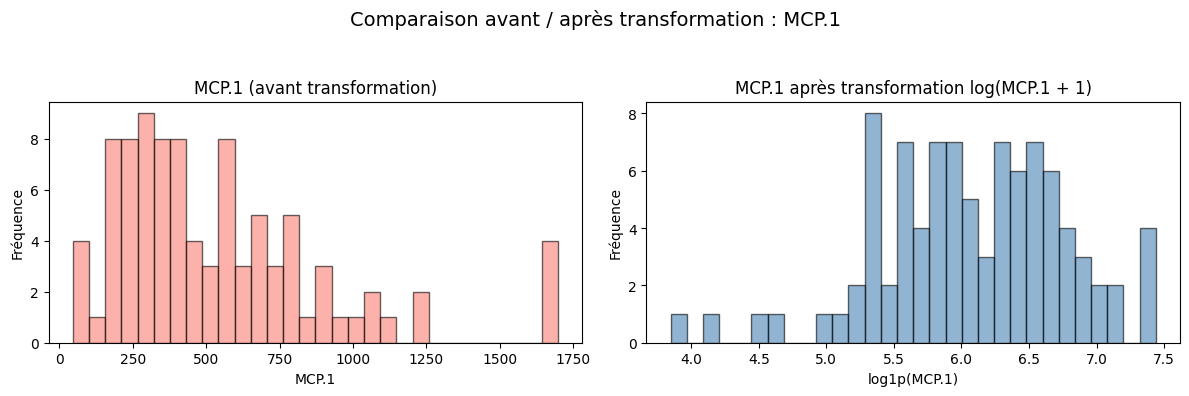

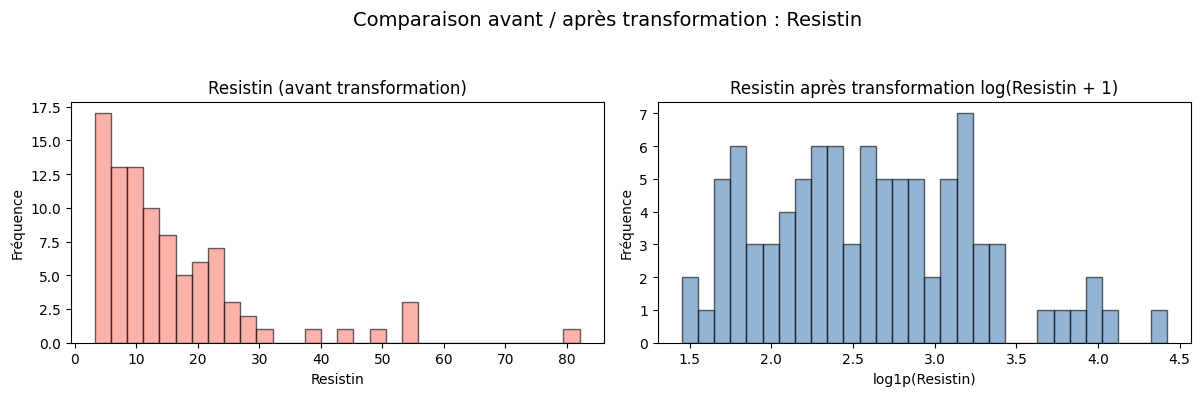

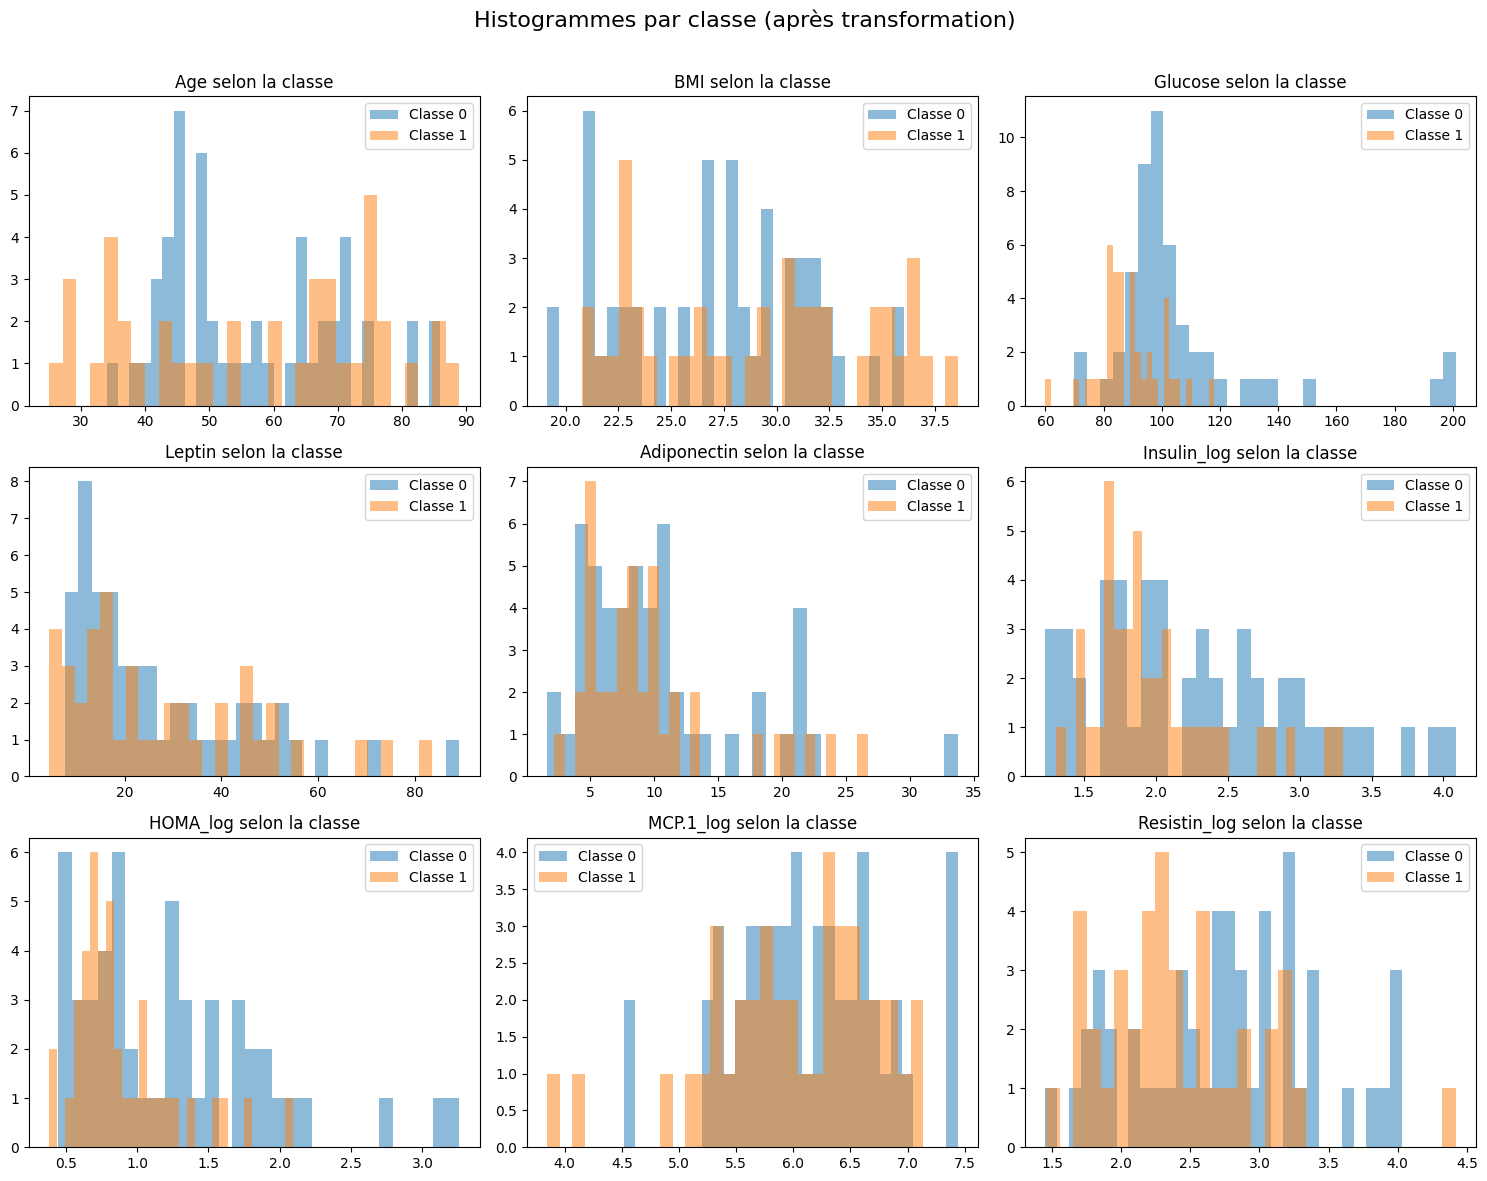

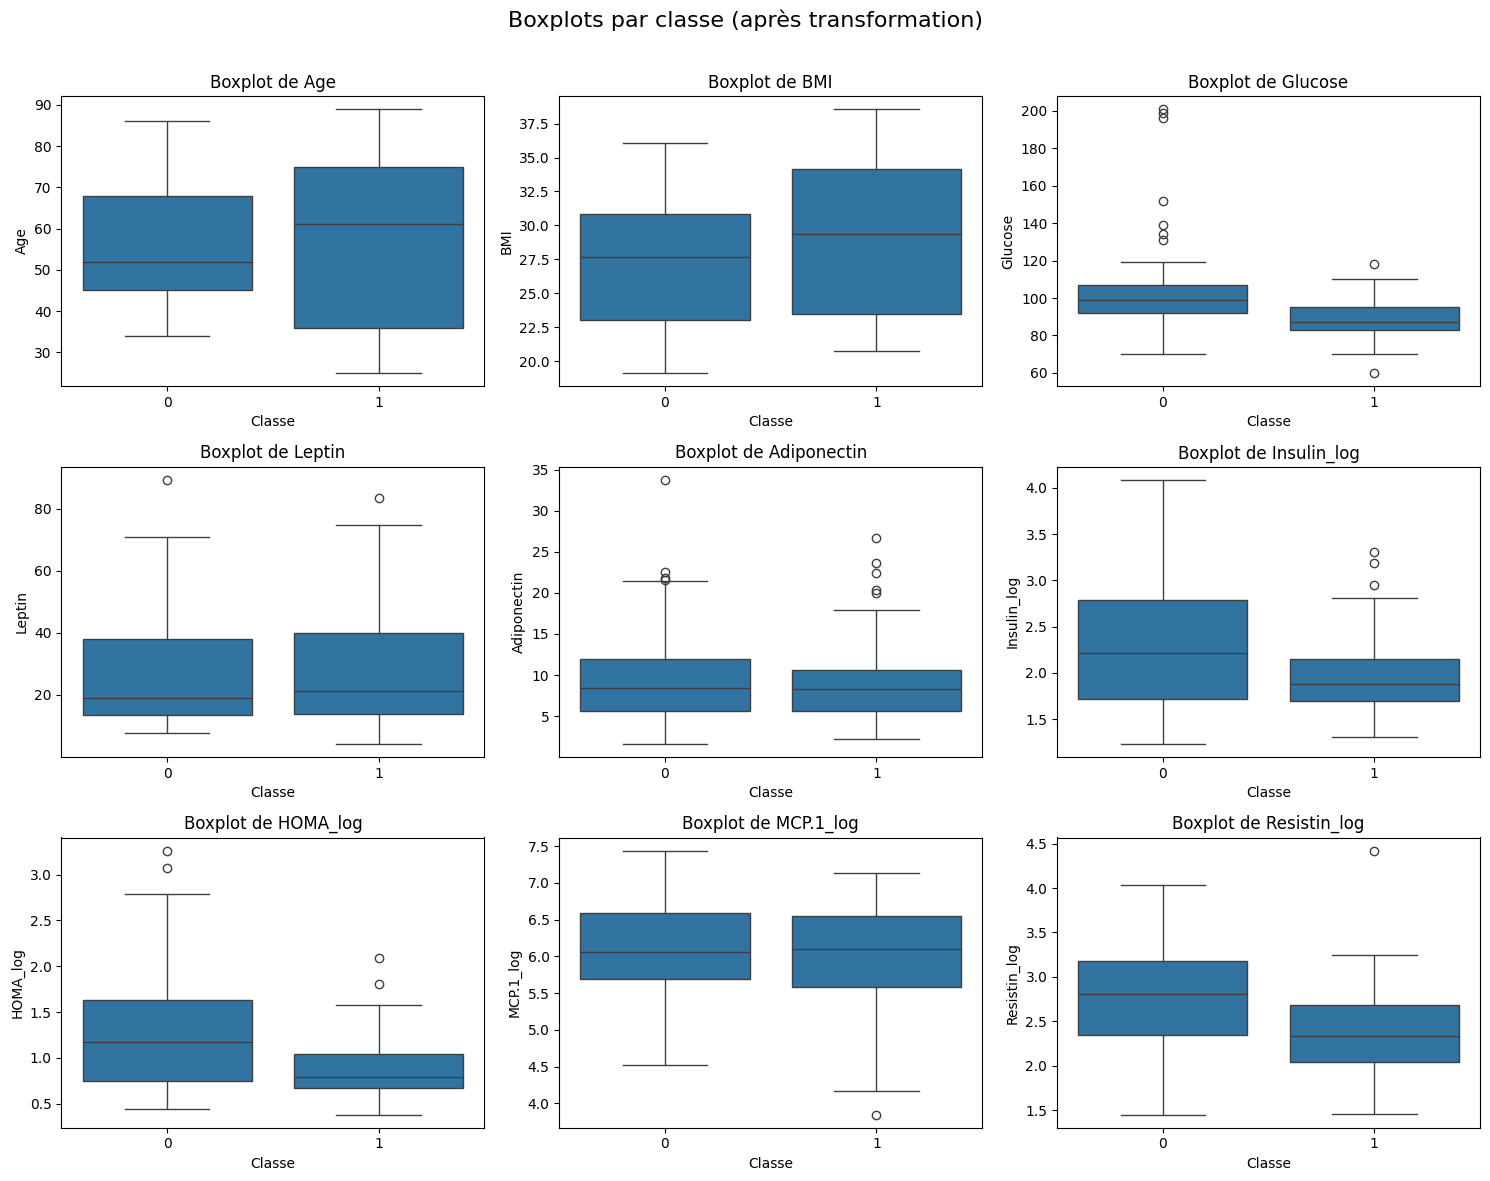

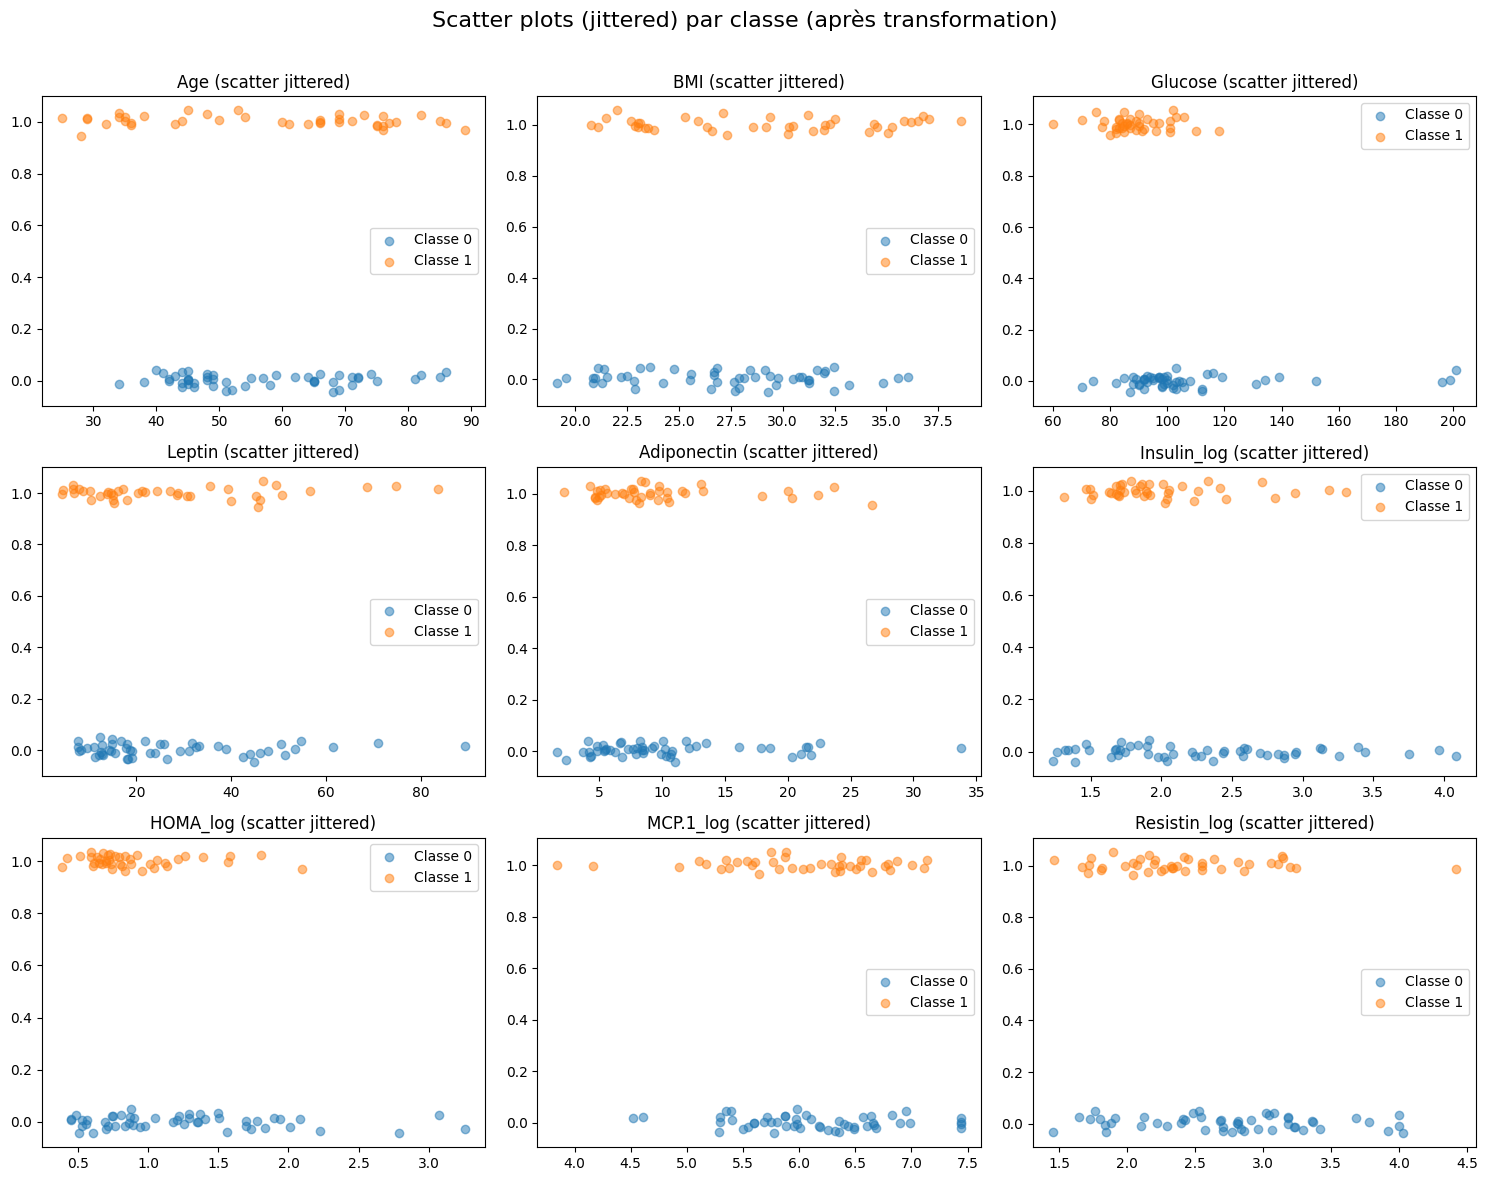

In [ ]:
# Liste des variables à transformer (asymétriques)
variables_log = ['Insulin', 'HOMA', 'MCP.1', 'Resistin']

# Comparaison avant / après (1 figure par variable)
for col in variables_log:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Avant transformation
    axes[0].hist(X_train[col], bins=30, alpha=0.6, color='salmon', edgecolor='black')
    axes[0].set_title(f"{col} (avant transformation)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Fréquence")

    # Après transformation log1p
    transformed = np.log1p(X_train[col])
    axes[1].hist(transformed, bins=30, alpha=0.6, color='steelblue', edgecolor='black')
    axes[1].set_title(f"{col} après transformation log({col} + 1)")
    axes[1].set_xlabel(f"log1p({col})")
    axes[1].set_ylabel("Fréquence")

    plt.suptitle(f"Comparaison avant / après transformation : {col}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Application de la transformation à X_train
X_train_transformed = X_train.copy()
for col in variables_log:
    X_train_transformed[col + '_log'] = np.log1p(X_train[col])
X_train_transformed = X_train_transformed.drop(columns=variables_log)

# Mise à jour des features transformées
features = X_train_transformed.columns.tolist()

# Fusion avec y_train pour faciliter les visualisations
train_data2 = X_train_transformed.copy()
train_data2['Classification'] = y_train.values

# Histogrammes par classe
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    for classe in [0, 1]:
        axes[i].hist(train_data2[train_data2['Classification'] == classe][col], 
                     bins=30, alpha=0.5, label=f"Classe {classe}")
    axes[i].set_title(f"{col} selon la classe")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histogrammes par classe (après transformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Boxplots par classe

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x='Classification', y=col, data=train_data2, ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots par classe (après transformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Scatter plots jittered par classe

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    for classe in [0, 1]:
        values = train_data2[train_data2['Classification'] == classe][col]
        jittered_y = np.random.normal(loc=classe, scale=0.02, size=values.shape)
        axes[i].scatter(values, jittered_y, alpha=0.5, label=f"Classe {classe}")
    axes[i].set_title(f"{col} (scatter jittered)")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Scatter plots (jittered) par classe (après transformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



### Objectif

L'analyse exploratoire initiale a révélé une **asymétrie marquée** (distribution fortement étalée à droite) pour plusieurs variables : `Insulin`, `HOMA`, `MCP.1` et `Resistin`.  
Ces distributions comportaient de nombreuses valeurs extrêmes susceptibles de nuire à l’apprentissage de certains modèles (régression logistique, k-NN, SVM...) sensibles aux écarts de grandeur ou à la non-normalité.

Afin de rendre ces distributions plus symétriques et de réduire l’impact des valeurs extrêmes, nous avons appliqué une **transformation logarithmique** de type `log(x + 1)` à l’aide de la fonction `np.log1p`.

---

### Comparaison avant / après transformation

Pour chaque variable transformée, nous avons comparé la distribution **avant et après transformation** à l’aide d’un histogramme :

- On observe que les longues traînes à droite sont **fortement atténuées**.
- Les distributions deviennent **plus compactes, moins asymétriques** et souvent plus proches d’une forme gaussienne.
- Cela améliore l’homogénéité du jeu de données et facilite les étapes de **standardisation** ultérieures.

Ces figures constituent une **justification visuelle explicite** de l’intérêt de la transformation logarithmique.

---

### Mise à jour du jeu de données

Les nouvelles variables transformées (`Insulin_log`, `HOMA_log`, `MCP.1_log`, `Resistin_log`) ont été ajoutées au jeu de données, et les anciennes supprimées pour éviter toute redondance.

---

### Visualisation des variables transformées par classe

Afin d’observer l’effet de cette transformation sur la répartition des valeurs dans les deux classes (malade / sain), nous avons reproduit plusieurs visualisations sur les variables transformées :

#### • Histogrammes par classe  
Ces histogrammes permettent de visualiser les densités relatives dans chaque classe, après transformation.  
On constate que certaines variables, notamment `Insulin_log` et `Resistin_log`, présentent toujours des différences de densité entre les classes, mais avec une **distribution beaucoup plus régulière**.

#### • Boxplots par classe  
La transformation log réduit clairement l'impact des **outliers visibles** dans les boxplots.  
Les médianes sont plus représentatives et les intervalles interquartiles moins éclatés.

#### • Scatter plots jittered  
Ces visualisations montrent que les points restent bien séparés verticalement entre les classes 0 et 1, tout en bénéficiant d’une **distribution horizontale plus contrôlée**, ce qui est favorable aux modèles à base de distance.

---

### Conclusion

L’application de la transformation logarithmique a permis de :
- Réduire les effets des valeurs extrêmes,
- Stabiliser la variance,
- Améliorer la structure géométrique du jeu de données en vue de la standardisation et de l'apprentissage.

Ces transformations constituent une **étape essentielle du pipeline de prétraitement** avant la construction des modèles.


# Étape 6 — Standardisation (StandardScaler)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialisation du scaler
scaler = StandardScaler()

# Entraînement du scaler sur le jeu transformé
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

X_train_scaled.describe().T[['mean', 'std']]


,mean,std
Age,1.037817e-16,1.005479
BMI,-8.447349e-17,1.005479
Glucose,1.995309e-16,1.005479
Leptin,6.033821e-17,1.005479
Adiponectin,1.436049e-16,1.005479
Insulin_log,2.292852e-16,1.005479
HOMA_log,-3.891814e-16,1.005479
MCP.1_log,-7.406515e-16,1.005479
Resistin_log,-1.680419e-16,1.005479


### Objectif

Après transformation logarithmique des variables asymétriques, nous appliquons une **standardisation** à l’ensemble des variables explicatives du jeu d’entraînement.  
Cette étape vise à **mettre toutes les variables sur une même échelle**, en les centrant autour de 0 et en les réduisant à une variance unitaire.

La standardisation est particulièrement importante pour les modèles sensibles aux distances ou aux écarts d’échelle, tels que :
- la régression logistique (convergence plus stable),
- le SVM,
- les k plus proches voisins (k-NN),
- les méthodes de régularisation (Ridge, Lasso),
- ou encore les techniques de réduction de dimension (PCA, etc.).

---
### Méthode

La transformation utilisée est la standardisation classique (Z-score), via la formule :

$$
X^{(i)}_{\text{std}} = \frac{X^{(i)} - \mu^{(i)}}{\sigma^{(i)}}
$$

où \( \mu^{(i)} \) et \( \sigma^{(i)} \) désignent respectivement la moyenne et l’écart-type de la variable \( X^{(i)} \) sur l’ensemble d’entraînement.

Nous utilisons l’outil `StandardScaler` de `scikit-learn`, appliqué uniquement sur les données d’entraînement (`fit_transform`) pour éviter toute fuite d’information.



# Étape 7 — Préparation de X_test

In [ ]:
# Copie de X_test
X_test_transformed = X_test.copy()

# Appliquer les mêmes log-transforms
for col in variables_log:
    X_test_transformed[col + '_log'] = np.log1p(X_test_transformed[col])

# Supprimer les colonnes originales
X_test_transformed = X_test_transformed.drop(columns=variables_log)

# Standardiser avec le scaler déjà entraîné sur X_train
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

# Vérifie que les colonnes de X_test sont identiques (et dans le même ordre) à celles de X_train, pour éviter des erreurs de prédiction
if list(X_train_scaled.columns) != list(X_test_scaled.columns):
    print( "Mismatch between train and test columns")


Les transformations précédemment appliquées sur le jeu d'entraînement (logarithmisation + standardisation) doivent être reproduites **exactement à l’identique** sur le jeu de test, sans réestimer les paramètres.

### Étapes réalisées :
1. **Transformation logarithmique** sur les mêmes variables (`Insulin`, `HOMA`, `MCP.1`, `Resistin`), via `log(x + 1)` ;
2. **Suppression des variables brutes** pour éviter la redondance ;
3. **Standardisation avec les mêmes paramètres** (`μ`, `σ`) appris sur `X_train`, à l’aide de `scaler.transform()`.

Nous avons également vérifié que les **colonnes de `X_test_scaled` sont strictement les mêmes (et dans le même ordre)** que celles de `X_train_scaled`, afin de garantir la compatibilité avec les modèles d’apprentissage.

---

Cette étape complète le pipeline de prétraitement et nous permet désormais de passer à la **modélisation supervisée**.


# Étape 8 — Modélisation avec LogisticRegression

In [ ]:
# Entraînement initial du modèle de régression logistique (sans régularisation explicite)

from sklearn.linear_model import LogisticRegression
# Initialisation du modèle
logreg_simple = LogisticRegression(random_state=42)

# Entraînement sur les données standardisées
logreg_simple.fit(X_train_scaled, y_train)

# Prédictions sur le test
y_pred = logreg_simple.predict(X_test_scaled)

# Évaluation des performances (jsp si c'est utile de faire ça ici)
print("Nombre de prédictions positives :", y_pred.sum())
print("Nombre réel de cas positifs dans y_test :", y_test.sum())



Nombre de prédictions positives : 12
Nombre réel de cas positifs dans y_test : 11


# Étape 9 — Validation croisée (cross-validation)

Validation croisée (10 folds)
F1-score moyen : 0.696 ± 0.187
Accuracy moyen : 0.731 ± 0.175


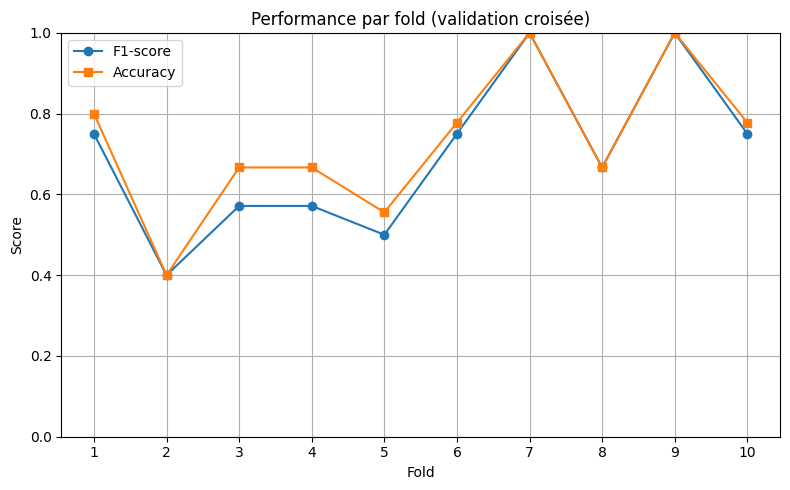

In [ ]:
from sklearn.model_selection import cross_val_score

# Initialisation du modèle
logreg_cv = LogisticRegression(random_state=42)

# Validation croisée avec scoring F1
f1_scores = cross_val_score(logreg_cv , X_train_scaled, y_train, cv=10, scoring='f1')
acc_scores = cross_val_score(logreg_cv , X_train_scaled, y_train, cv=10, scoring='accuracy')

# Résumé
print("Validation croisée (10 folds)")
print(f"F1-score moyen : {f1_scores.mean():.3f} ± {f1_scores.std():.3f}") 
print(f"Accuracy moyen : {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")


# Visualisation des scores de validation croisée
folds = range(1, len(f1_scores) + 1)
plt.figure(figsize=(8, 5))
plt.plot(folds, f1_scores, marker='o', label='F1-score')
plt.plot(folds, acc_scores, marker='s', label='Accuracy')

plt.title("Performance par fold (validation croisée)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Afin d’évaluer la robustesse du modèle de régression logistique, nous avons effectué une validation croisée à 10 folds.  
Chaque fold permet d’entraîner le modèle sur 90 % des données d’entraînement, puis de l’évaluer sur les 10 % restants.

Nous avons suivi l’évolution du **F1-score** et de l’**accuracy** à chaque fold, ce qui permet d’observer la stabilité du modèle.

- Le **F1-score moyen** est de **0.696**, avec un écart-type de **0.187**
- L'**accuracy moyenne** est de **0.731**, avec un écart-type de **0.175**

Ces résultats montrent que le modèle présente des performances correctes mais **variables** selon la partition des données.  
Cette variabilité est attendue dans le cas d’un **petit jeu de données**, et justifie la suite de la démarche par une **optimisation via régularisation**.


# Étape 10 — Évaluation du modèle sur le test set

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : ", round(accuracy, 3))

# F1-score (binaire par défaut)
f1 = f1_score(y_test, y_pred)
print("F1-score :",round(f1, 3))

# Rapport complet
print("\nClassification Report :")
print(classification_report(y_test, y_pred))


Accuracy :  0.792
F1-score : 0.783

Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.75      0.82      0.78        11

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.80      0.79      0.79        24



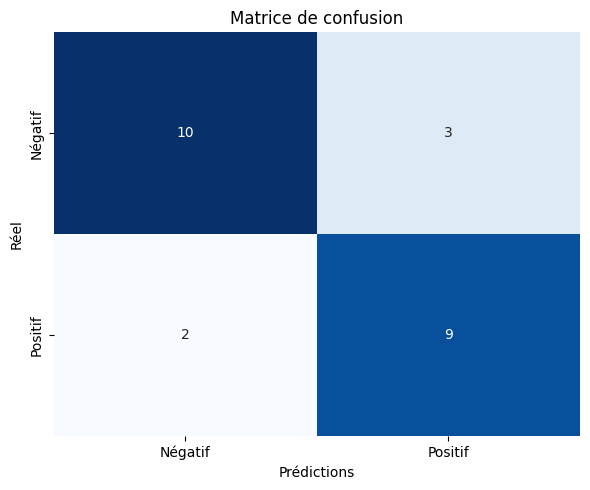


Coefficients du modèle :
        Feature  Coefficient
1           BMI     0.815422
0           Age     0.286680
5   Insulin_log     0.048883
3        Leptin     0.026291
7     MCP.1_log    -0.290218
4   Adiponectin    -0.301358
6      HOMA_log    -0.583908
8  Resistin_log    -0.700961
2       Glucose    -1.673655


/var/folders/kz/yn6r06915yl8rm1zpm_51j800000gn/T/ipykernel_69987/2534653591.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


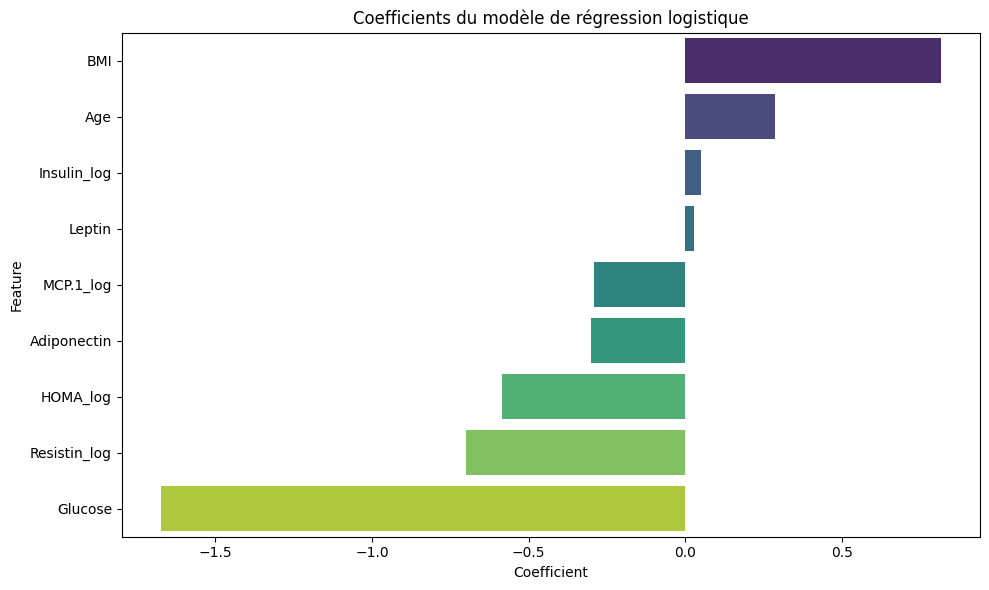

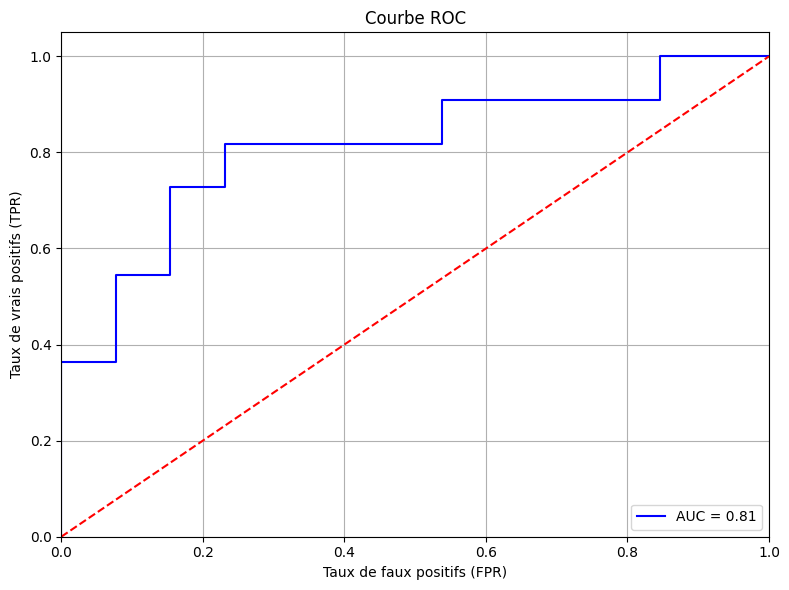

In [ ]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


# Coefficients du modèle
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': logreg_simple.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nCoefficients du modèle :")
print(coefficients)
# Visualisation des coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title("Coefficients du modèle de régression logistique")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Courbe ROC et AUC
from sklearn.metrics import roc_curve, auc
# Calcul des probabilités de prédiction
y_proba = logreg_simple.predict_proba(X_test_scaled)[:, 1]
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calcul de l'AUC
roc_auc = auc(fpr, tpr)  
# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonale
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

###  Analyse finale du modèle de régression logistique

L'évaluation complète du modèle sur le jeu de test montre des **résultats satisfaisants**, malgré la taille réduite du dataset :

-  **Matrice de confusion** : le modèle identifie correctement **9 cas positifs sur 11**, et limite les fausses alertes à **3 faux positifs**.
-  **Courbe ROC** : l'AUC atteint **0.81**, ce qui traduit une **bonne capacité de discrimination** entre patients atteints et non atteints.
-  **Analyse des coefficients** :
  - Les variables les plus influentes sont `BMI` (positif) et `Glucose` (négatif).
  - Cela donne une **lecture interprétable** du comportement du modèle.
-  **Équilibre des performances** : la **précision** et le **rappel** sont proches sur les deux classes, ce qui reflète un bon compromis.

Ces résultats montrent que la régression logistique, bien prétraitée (transformation + standardisation), permet d'obtenir un modèle à la fois **efficace** et **interprétable**, ce qui est essentiel dans un contexte biomédical.


# Étape 11: Régularisation

In [ ]:
from sklearn.model_selection import GridSearchCV
# Grille d’hyperparamètres à tester
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']  # nécessaire pour l1
}
# Initialisation du modèle de régression logistique pour la recherche de grille
logreg_grid = LogisticRegression(random_state=42, max_iter=1000)

# Recherche de grille avec validation croisée
grid_search = GridSearchCV(logreg_grid, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

# Meilleur modèle
best_logreg = grid_search.best_estimator_

# Prédictions finales
y_pred_best = best_logreg.predict(X_test_scaled)

# Meilleurs paramètres
print("Best params :", grid_search.best_params_)
print("Best F1-score :", grid_search.best_score_)


print("\nÉvaluation sur le jeu de test :")
print("Accuracy :", round(accuracy_score(y_test, y_pred_best), 3))
print("F1-score :", round(f1_score(y_test, y_pred_best), 3))
print("\nClassification Report :")
print(classification_report(y_test, y_pred_best))



Best params : {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1-score : 0.7371428571428572

Évaluation sur le jeu de test :
Accuracy : 0.792
F1-score : 0.762

Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.80      0.73      0.76        11

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24



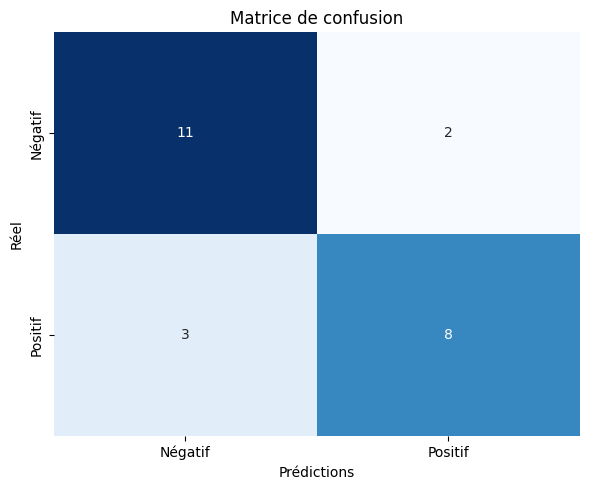


Coefficients du modèle :
        Feature  Coefficient
5   Insulin_log     2.661888
1           BMI     1.017807
0           Age     0.423608
3        Leptin    -0.014790
4   Adiponectin    -0.374322
7     MCP.1_log    -0.434532
8  Resistin_log    -0.844157
2       Glucose    -1.678957
6      HOMA_log    -3.778132


/var/folders/kz/yn6r06915yl8rm1zpm_51j800000gn/T/ipykernel_69987/3329826649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


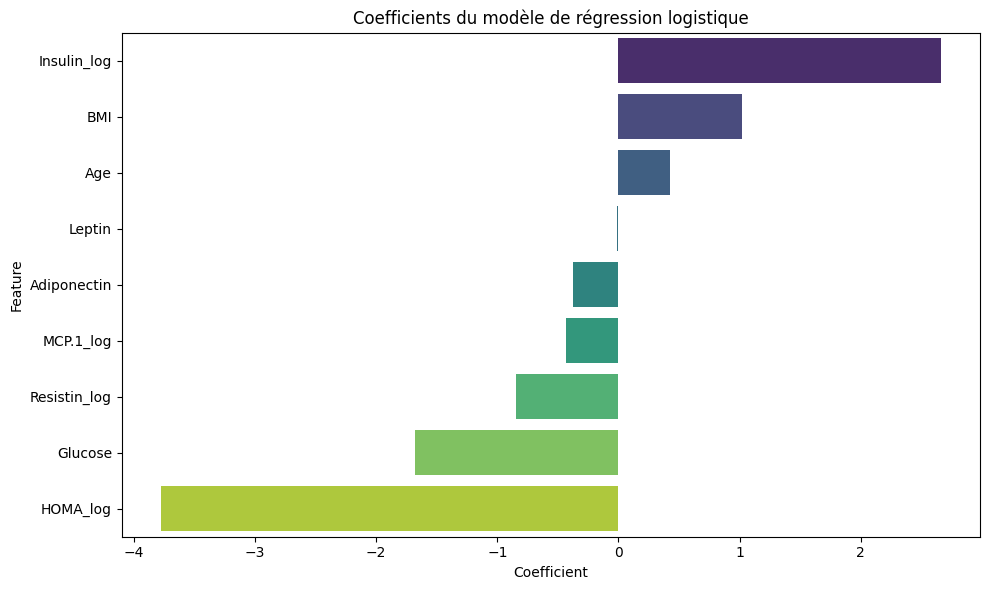

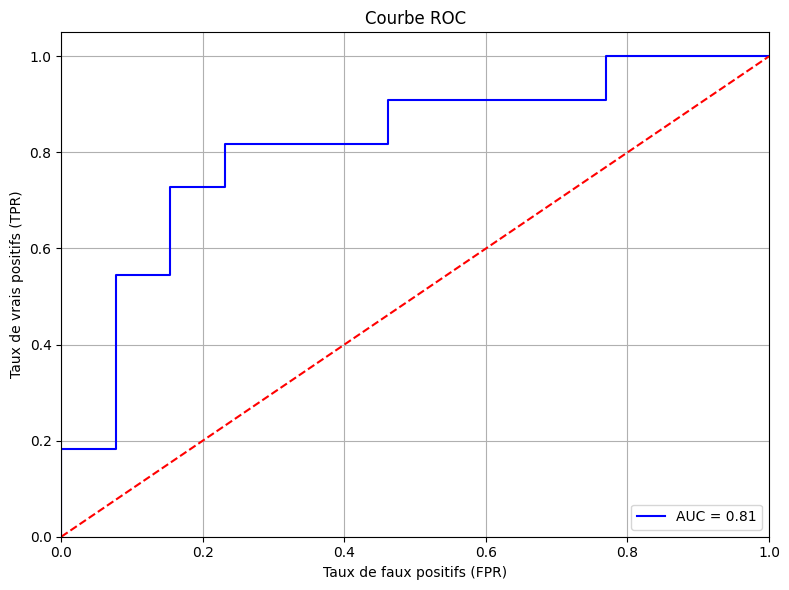

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


# Coefficients du modèle
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nCoefficients du modèle :")
print(coefficients)
# Visualisation des coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title("Coefficients du modèle de régression logistique")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Courbe ROC et AUC
# Calcul des probabilités de prédiction
y_proba_grid = best_logreg.predict_proba(X_test_scaled)[:, 1]
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_grid)
# Calcul de l'AUC
roc_auc = auc(fpr, tpr)  
# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonale
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

###  Analyse finale du modèle régularisé (Logistic Regression + GridSearchCV)

Après optimisation des hyperparamètres par validation croisée (GridSearchCV), le modèle final de régression logistique a été évalué sur le jeu de test. Voici les principaux résultats :

####  Matrice de confusion :
- Le modèle détecte **8 vrais positifs** sur 11, et **11 vrais négatifs** sur 13.
- Cela montre un bon équilibre entre sensibilité et spécificité.

#### Coefficients du modèle :
- Les variables ayant le plus d'influence sont :
  - **Insulin_log** (positif) → facteur prédictif fort de la classe 1 (cancer),
  - **BMI** (positif) et **Age** (positif),
  - **Glucose**, **HOMA_log** et **Resistin_log** (coefficients négatifs) → indicateurs protecteurs selon le modèle.
- Ces coefficients sont **interprétables** grâce à la régression linéaire et confirment des liens biomédicaux plausibles.

#### Courbe ROC :
- L'aire sous la courbe (**AUC**) est de **0.81**, indiquant une **bonne capacité de discrimination** du modèle.
- La courbe ROC montre que le modèle est capable de bien différencier les patients atteints ou non de cancer.

---

Ces résultats sont encourageants, d'autant plus que le dataset est **petit**.  
Le modèle a été rigoureusement entraîné avec :
- Prétraitement des variables (log + standardisation),
- Validation croisée,
- Optimisation par régularisation (`l1`/`l2` via `GridSearchCV`),
- Évaluation finale sur un jeu de test.

**Conclusion** : La régression logistique régularisée est un **modèle performant, stable et interprétable**, bien adapté à cette tâche de détection binaire.



Comparaison des modèles :
                   Accuracy  F1-score    AUC
Modèle simple         0.792     0.783  0.811
Modèle CV             0.792     0.783  0.811
Modèle régularisé     0.792     0.762  0.811


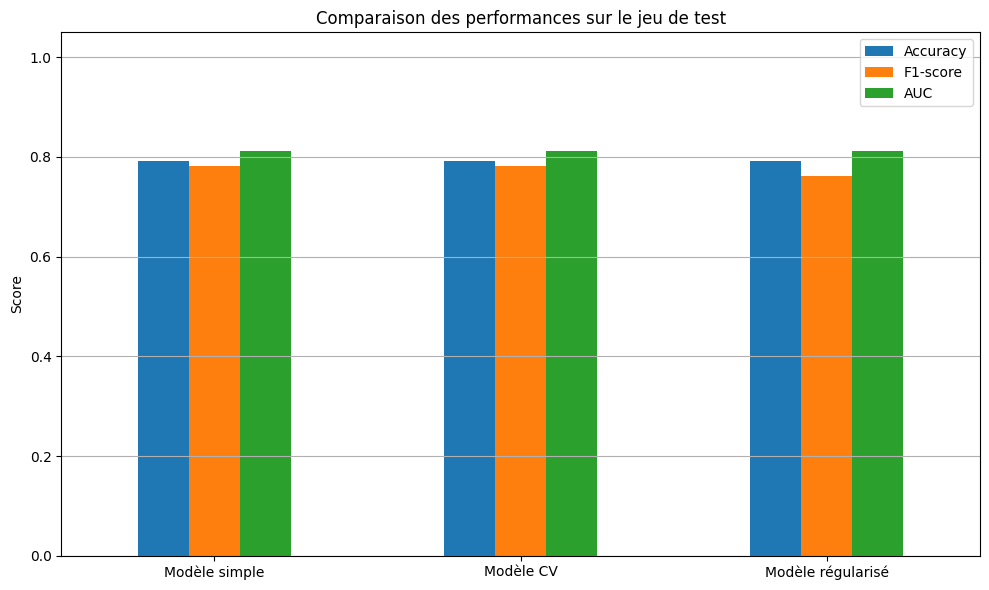

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Liste des modèles à comparer
model_names = ["Modèle simple", "Modèle CV", "Modèle régularisé"]
models = [logreg_simple, logreg_cv, best_logreg]

# Dictionnaires pour stocker les résultats
results = {
    "Accuracy": [],
    "F1-score": [],
    "AUC": []
}

# Évaluation de chaque modèle
logreg_cv.fit(X_train_scaled, y_train)

for model in models:
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["F1-score"].append(f1_score(y_test, y_pred))
    results["AUC"].append(roc_auc_score(y_test, y_proba))

# Affichage sous forme de DataFrame
df_results = pd.DataFrame(results, index=model_names)
print("\nComparaison des modèles :")
print(df_results.round(3))

# Visualisation
df_results.plot(kind='bar', figsize=(10, 6))
plt.title("Comparaison des performances sur le jeu de test")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


 Les résultats très similaires entre les versions du modèle suggèrent que la régression logistique capture efficacement la structure du jeu de données, sans sur-apprentissage apparent. La régularisation n’a pas apporté de gain de performance notable, ce qui est cohérent avec la petite taille du dataset et la simplicité du modèle. 